> ### Object Localization

In [2]:
import os
import numpy as np
import pandas as pd
import pickle
import glob

# Plotting
import imageio
import PIL
from PIL import ImageDraw, Image
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus']=False 

# Framework
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms
import torch.nn.functional as F

#### Data

In [49]:
(train, test), info = tfds.load("mnist", with_info=True, split=['train', 'test'])
train
test

<PrefetchDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>

<PrefetchDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>

In [50]:
train_num = info.splits['train'].num_examples
test_num = info.splits['test'].num_examples
num_classes = info.features['label'].num_classes
print(train_num)
print(test_num)
print(num_classes)

60000
10000
10


In [51]:
#通过padding，人工创建localization的training set
def preprocess(dataset):  
    images, labels = dataset['image'], dataset['label'] 
    ymin = tf.random.uniform((),0,48, dtype=tf.int32) #生成0到47的随机整数
    xmin = tf.random.uniform((),0,48, dtype=tf.int32) #由于28+47=75
    images = tf.reshape(images,[28,28,1]) #模型首层是Conv
    
    # 在图片top和left分别增加多少行/列的0，最终生成75长宽的正方形，即剩余bottom和right补0
    images = tf.image.pad_to_bounding_box(images, ymin, xmin, 75, 75)
    images = tf.cast(images, tf.float32)/255.0 #0-1，使得padding为0黑底
    
    # Bounding box是根据图片长宽的相对位置，得到coordinates
    xmin = tf.cast(xmin, tf.float32) #后续除
    ymin = tf.cast(ymin, tf.float32)
    xmin = xmin / 75
    ymin = ymin / 75
    xmax = (xmin + 28) / 75
    ymax = (ymin + 28) / 75
    labels = tf.one_hot(labels, 10) #转成10类别的one-hot
    bboxes = [xmin, ymin, xmax, ymax]
    return images, (labels, bboxes) 

def prepare_train_dataset(train, buffer_size=1024, batch_size=64):
    train = (train
            .map(preprocess) 
            .shuffle(buffer_size=buffer_size) 
            .batch(batch_size=batch_size, drop_remainder=True) 
            .prefetch(tf.data.experimental.AUTOTUNE)) 
    return train

def prepare_test_dataset(test, batch_size=64):
    test = (test
            .map(preprocess)
            .batch(batch_size=batch_size, drop_remainder=True)) 
    return test

In [52]:
BUFFER_SIZE = 5000
BATCH_SIZE = 64 

In [53]:
train = prepare_train_dataset(train, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE)
test = prepare_test_dataset(test, batch_size=test_num) #一次性加载
train
test

<PrefetchDataset shapes: ((64, 75, 75, 1), ((64, 10), (64, 4))), types: (tf.float32, (tf.float32, tf.float32))>

<BatchDataset shapes: ((10000, 75, 75, 1), ((10000, 10), (10000, 4))), types: (tf.float32, (tf.float32, tf.float32))>

#### Model

In [56]:
inputs = layers.Input(shape=(75, 75, 1,))
x = layers.Conv2D(16, activation='relu', kernel_size=3, input_shape=(75, 75, 1))(inputs)
x = layers.AveragePooling2D((2, 2))(x)
x = layers.Conv2D(32,kernel_size=3,activation='relu')(x)
x = layers.AveragePooling2D((2, 2))(x)
x = layers.Conv2D(64,kernel_size=3,activation='relu')(x)
x = layers.AveragePooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
labels = layers.Dense(10, activation='softmax', name='labels')(x)
bboxes = layers.Dense(4, name='bboxes')(x)

model = keras.Model(inputs = inputs, outputs = [labels, bboxes])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 75, 75, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 73, 73, 16)   160         input_2[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_3 (AveragePoo (None, 36, 36, 16)   0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 34, 34, 32)   4640        average_pooling2d_3[0][0]        
______________________________________________________________________________________________

In [57]:
model.compile(optimizer='adam', 
              loss = {'labels' : 'categorical_crossentropy', #因为是one-hot
                      'bboxes' : 'mse'},
              metrics = {'labels' : 'accuracy',
                         'bboxes' : 'mse'})

history = model.fit(train, steps_per_epoch=int(train_num//BATCH_SIZE), #n_batches/epoch
                    validation_data=test, validation_steps=1, #因为test是整体加载
                    epochs=10) 


Epoch 1/10
937/937 [==============================] - 215s 226ms/step - loss: 0.9878 - labels_loss: 0.9738 - bboxes_loss: 0.0141 - labels_accuracy: 0.6575 - bboxes_mse: 0.0141 - val_loss: 0.2999 - val_labels_loss: 0.2917 - val_bboxes_loss: 0.0082 - val_labels_accuracy: 0.9107 - val_bboxes_mse: 0.0082
Epoch 2/10
937/937 [==============================] - 167s 177ms/step - loss: 0.2674 - labels_loss: 0.2614 - bboxes_loss: 0.0060 - labels_accuracy: 0.9206 - bboxes_mse: 0.0060 - val_loss: 0.2118 - val_labels_loss: 0.2067 - val_bboxes_loss: 0.0051 - val_labels_accuracy: 0.9355 - val_bboxes_mse: 0.0051
Epoch 3/10
937/937 [==============================] - 162s 172ms/step - loss: 0.1928 - labels_loss: 0.1889 - bboxes_loss: 0.0038 - labels_accuracy: 0.9424 - bboxes_mse: 0.0038 - val_loss: 0.1538 - val_labels_loss: 0.1504 - val_bboxes_loss: 0.0034 - val_labels_accuracy: 0.9541 - val_bboxes_mse: 0.0034
Epoch 4/10
937/937 [==============================] - 177s 188ms/step - loss: 0.1612 - labels_

#### Evaluation

In [60]:
model.evaluate(test, steps=1)

1/1 [==============================] - 13s 13s/step - loss: 0.0671 - labels_loss: 0.0660 - bboxes_loss: 0.0011 - labels_accuracy: 0.9786 - bboxes_mse: 0.0011


[0.06711210310459137,
 0.06604460626840591,
 0.0010674934601411223,
 0.978600025177002,
 0.0010674934601411223]

In [63]:
def plot_metrics(history, string):
    plt.plot(history.history[string],label=string)
    plt.plot(history.history['val_'+string],label='val_'+string)
    plt.xlabel("Epochs")
    plt.title(string.capitalize())
    plt.legend()
    plt.show()

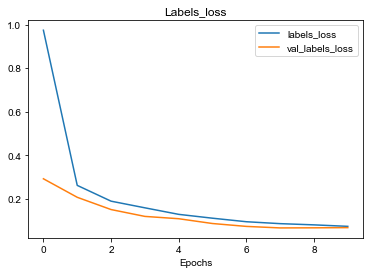

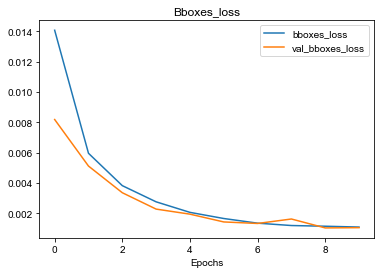

In [64]:
plot_metrics(history, "labels_loss")
plot_metrics(history, 'bboxes_loss')

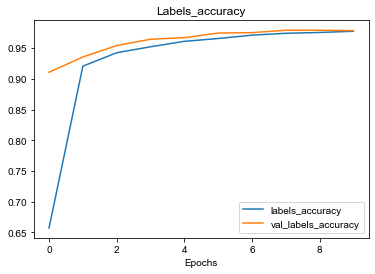

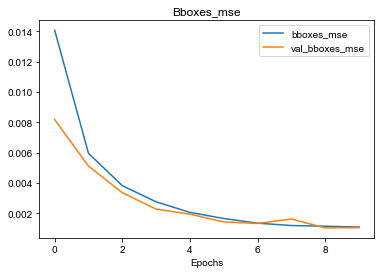

In [65]:
plot_metrics(history, "labels_accuracy")
plot_metrics(history, 'bboxes_mse')

In [74]:
def iou(bboxes, y_pred_bboxes, smoothing_factor = 1e-10): #降低noise
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(bboxes, 4, axis = 1)
    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(y_pred_bboxes, 4, axis = 1)
    
    # Coordinates 
    xmin = np.maximum(xmin_pred, xmin_true)
    xmax = np.minimum(xmax_pred, xmax_true)
    ymin = np.maximum(ymin_pred, ymin_true)
    ymax = np.minimum(ymax_pred, ymax_true)

    # Areas
    y_pred_bbox_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)
    overlap_area = np.maximum((xmax - xmin), 0)  * np.maximum((ymax - ymin), 0)
    union_area = (y_pred_bbox_area + box_area) - overlap_area
    
    iou = (overlap_area+smoothing_factor)/(union_area+smoothing_factor)

    return iou

#### Prediction

In [221]:
def draw_bbox_on_image(image, xmin, ymin, xmax, ymax, color, thickness, 
                       normalized_coordinates):
    # 用PIL
    draw = ImageDraw.Draw(image) #在新图层上画
    if normalized_coordinates: #相对位置
        width, height = image.size
        (x1, y1, x2, y2) = (xmin*width, ymin*height, xmax*width, ymax*height)
    else:
        (x1, y1, x2, y2) = (xmin, ymin, xmax, ymax)
    draw.line([(x1, y1), (x1, y2), (x2, y2), (x2, y1), (x1, y1)], 
              width=thickness, fill=color) #从左上开始逆时针画
    return image


def draw_bboxes_on_image(image, boxes, color=['green','red'], #PIL
                         thickness=1, normalized_coordinates=True):
    image = Image.fromarray(image)
    overlay_box = Image.new("RGBA", image.size) #创建新图层画框，因为原图是一通道的数组
    overlay_box.paste(image)
    for i in range(boxes.shape[0]): #遍历所有boxes
        xmin, ymin, xmax, ymax = boxes[i]
        draw_bbox_on_image(overlay_box, xmin, ymin, xmax, ymax, color[i], 
                           thickness, normalized_coordinates) #在新图层上画框      
    
    return overlay_box


def display_image_with_bboxes(dataset, n, iou_threshold=0.6):
    val = dataset.unbatch().shuffle(BUFFER_SIZE).batch(n)
  
    plt.figure(figsize=(20,4))
    for images, (labels, bboxes) in val.take(1):
        (y_pred_labels, y_pred_bboxes) = model.predict(images)
        y_pred_labels = np.argmax(y_pred_labels, axis=1)
        labels = np.argmax(labels, axis=1)
        iou_score = iou(bboxes, y_pred_bboxes)
        images = images.numpy().reshape(n,75,75) #需要调整格式，才能后续转为图片
        images = images*255
        for i in range(n):
            plt.subplot(1,n,i+1)
            boxes = np.array([bboxes[i], y_pred_bboxes[i]])
            img_with_bboxes = draw_bboxes_on_image(images[i], boxes)
            plt.imshow(img_with_bboxes)
            label_correct = y_pred_labels[i]==labels[i]
            plt.title(f'{y_pred_labels[i]} ({"True" if label_correct else "should be "+labels[i]})', 
                      fontsize=12, color='green' if label_correct else 'red')
            
            iou_high = iou_score[i] > iou_threshold
            plt.xlabel('iou: {:.2f}'.format(iou_score[i][0]), fontsize=12, color='green' if iou_high else 'red')
            
            plt.xticks([])
            plt.yticks([])

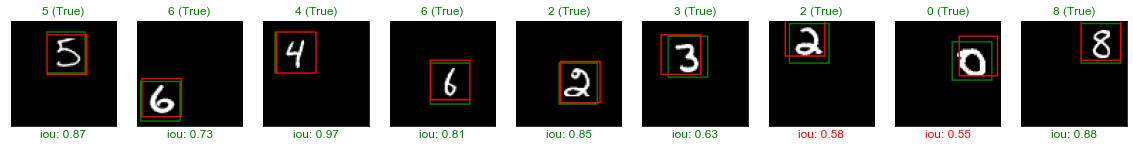

In [222]:
display_image_with_bboxes(test, 9)

In [180]:
# create digits from local fonts for testing
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")
def create_digits_from_local_fonts(n):
    font_labels = []
    img = PIL.Image.new('LA', (75*n, 75), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
    font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
    font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
    d = ImageDraw.Draw(img)
    for i in range(n):
        font_labels.append(i%10)
        d.text((7+i*75,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
        font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
        font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [75, 75*n]), n, axis=1), axis=0), [n, 75*75])
    return font_digits, font_labels